<a href="https://colab.research.google.com/github/SquareGraph/FootballPredictionsModel/blob/main/BaselineModels_Football_Predictions_55_60_version_to_publish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the model comparsion notebook. 
We will cover a bunch of models with a baseline data from a English Premier League, to distingiush potential and next steps.

The main reasoning behind this research is to create the algobetting robot. Whilst mode odds on home wins and distribution are around 1,16(distribution: ~43%), away wins 1,78(dist: ~34%) and draws 3,38(dist: ~23%), it means that:
(1,16*0,43+1,78*0,34+3,38*0,23) * accuracy of prediction should set a baseline for a ROI of this robot.

And math is very clear here: 

In [37]:
sum_of_odds = 1.16*0.43+1.78*0.34+3.38*0.23
print(f"The sum of odds in one season, if we type everything correct is: {round(sum_of_odds, 3)}")
print(f"So to have non negative ROI (not counting any commisions on money transfer), our algorithms accuracy must be accurate {round(1/sum_of_odds*100, 4)}% times.")

## data based on EPL season of 2021

The sum of odds in one season, if we type everything correct is: 1.881
So to have non negative ROI (not counting any commisions on money transfer), our algorithms accuracy must be accurate 53.1519% times.


## So we'll be covering following algorithms:

1. SKlearn RandomForestClassifier (no need of explanation)
2. XGBoost Classifier (no need of explanation)
3. PyTorch TabNet implementationby Dreamquark-ai:
  <br>  a) https://github.com/dreamquark-ai/tabnet - official docs of PyTorch implementation of the original algorithm
  <br>  b) https://arxiv.org/abs/1908.07442 - official research papers of TabNet
<br> c) https://www.geeksforgeeks.org/tabnet/ - a quick guide over the TabNet

4. DeepInisght with DeppInsight like architecture:
  <br>  a) DeepInsight paper: https://www.nature.com/articles/s41598-019-47765-6 - a methodology of converting tabular data to Images, article in Nature with some data
 <br>   b) https://github.com/nicomignoni/tab2img - a documentation of the implemenation of DeepInsight in a python library 
<br>    c) Disclaimer: this is a baseline approach, so I decided just to implement the one leg of proposed net. 

In [38]:
# Let's start from importing and mounting drive, cause we'll be working on a dataset prepared before in a following notebook:
# Notebook for Data Gathering https://github.com/SquareGraph/FootballPredictionsModel/blob/main/DataGathering_from_Soccerdata.ipynb
from IPython.utils.text import Path
from google.colab import drive 
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Paths declaration
path = Path('/content/drive/MyDrive/Github/FootballPredictionsModel')
data = 'data'

In [40]:
#Some standard imports
import pandas as pd
import numpy as np

In [41]:
main = pd.read_csv(path/data/"with_fifa_raw.csv") ; print(main.shape) # We have a lot of features here, 141!
main.head()

(380, 141)


,Unnamed: 0,date_x,home_team,away_team,game_id,Goal_x,Off Target_x,Saved_x,Woodwork_x,<10_x,...,33,34,35,36,37,38,39,40,41,42
0,0,2021-08-13 00:00:00,Brentford,Arsenal,3adf2aa7,1.500000,2.8,1.00,0.0,3.6,...,-2.757576,0.393939,-0.333333,-3.060606,-1.636364,-2.242424,-2.060606,-1.484849,-0.545455,-1.424242
1,1,2021-08-14 00:00:00,Burnley,Brighton & Hove Albion,4eb36e37,1.000000,2.6,2.00,0.0,2.2,...,1.060606,2.666667,0.212121,0.181818,-0.030303,0.333333,0.212121,0.484849,-0.454545,0.363636
2,2,2021-08-14 00:00:00,Chelsea,Crystal Palace,6f454493,1.400000,4.0,4.25,0.0,3.8,...,5.939394,3.787879,4.636363,5.151515,0.000000,1.484849,1.454546,0.151515,-0.636364,-1.666667
3,3,2021-08-14 00:00:00,Everton,Southampton,c99ebbf5,1.666667,4.0,2.00,0.0,3.0,...,6.636363,3.484849,1.878788,1.636364,0.181818,0.848485,0.363636,0.484849,0.424242,0.515151
4,4,2021-08-14 00:00:00,Leicester City,Wolverhampton Wanderers,0b346a62,1.000000,3.6,2.50,0.0,3.0,...,3.939394,3.545454,4.060606,3.151515,4.393940,3.545454,4.121212,3.454546,4.878788,2.636364


In [42]:
# list(main.columns)

In [43]:
main.dtypes[main.dtypes == "object"] # And here all non-numerical categories. 

date_x       object
home_team    object
away_team    object
game_id      object
date_y       object
dtype: object

# What to do with those features.
A Quick explanation:

1. Object data types:
   <br>a) We want to drop date_x and date_y features (as it seems not relevant to the game performance, without an information about additional games from other competition, and potential fatigue). From domain knowledge, raw date of a game it's a rubbish data I strongly believe.
    <br> b) Home_team and away_team - assign each team a number, and treat them like every other numerical data. There's some logic behind this reasoning. Explain further in the document.
    <br> c) game_id - absolutely unnecessary.

2.  Numerical data types to drop from the features:

    a) FTR - those are our Y values. We want to drop them before assining to the X values.
   <br> b) D_HT, home_point,draw_points,away_points - A lost remains of some computation did during that processing. Absolutely to drop.
  <br>  c) Unnamed: 0 - index like, probably effect of merging without droping index params. Drop.

3. Numerical data types - Legend
   <br> a) Columns named from 0 to 42: it's a SoFifa mean params, substracted between home and away.
  <br>  b) home_rank, away_rank - ELO Rank at the day of a game
  <br> c) all duplicated columns - rolling average (5 games window) for each team performance






# Team name transofmration

Probably the team name may also affect the game result. For example if you are playing against strong rival your mental approach may vary from challenging the weaker one. So let's translate team names into integer values from 1 to 20.

In [44]:
team_integers = dict(zip(np.unique(main.home_team.to_numpy()),np.arange(1,21))) #dict from zip from unique team names labeled by the np arange.
main.replace(team_integers, inplace=True) #replace all through dictionary method.

# Prepare Raw, unnormalized data for initial baseline training.

We want to start with a baseline models just from the raw data.
But let's also check if time series character vary training or not. So we will build two different datasets. One that will be randomly splited, and the second one that takes first 80% of games for a training dataset and predict on the last 20%. Let's call them X_ts,y_ts for timeserieswise variation, and X_rand, y_rand for randomly splitted.

In [45]:
main_dropped = main.drop(["date_x","date_y","game_id","Unnamed: 0","D_HT","home_point","draw_points","away_points"],axis=1) # we are dropping all columns mentioned above

In [46]:
y = main_dropped.FTR.to_numpy() #labels
X = main_dropped.drop(["FTR"],axis=1).fillna(0).to_numpy() ## all nan comes from the effect of calculating rolling average (division by 0 at some point) or no records, so filling with 0 is not a bad idea.

In [47]:
X_downscale = main_dropped.drop(["FTR"],axis=1).apply(lambda x: x/x.max()).fillna(0).to_numpy()  # downscale to numbers ranging from 0 to 1 (in some cases to -1)

In [48]:
## We will use our own train test split, because want to keep chronological order as those are time series data.

def train_test_split_ts(features, targets, train_size=0.8):

    """Returns two tuples of Train and test sests, in X,y order."""

    TRAIN_SIZE = int(features.shape[0]*train_size)
    X_ts_train, y_ts_train = features[:TRAIN_SIZE], targets[:TRAIN_SIZE]
    X_ts_test, y_ts_test = features[TRAIN_SIZE:], targets[TRAIN_SIZE:]



    return (X_ts_train, y_ts_train), (X_ts_test, y_ts_test)

In [49]:
train_ts, test_ts = train_test_split_ts(X,y) # split into tuples

In [50]:
#unpack tuples for all other models
X_train_ts, y_train_ts = train_ts 
X_test_ts, y_test_ts = test_ts

# First model RandomForestClassifier from sklearn
We starts with a RandomForest for our absolute baseline.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [52]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [53]:
rf.fit(X_train_ts, y_train_ts) # train the baseline model

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [54]:
rf_preds = np.argmax(rf.predict_proba(X_test_ts), axis=1) # make prediction and call the argmax to have an index of the highest probability

In [55]:
rf_acc = accuracy_score(y_test_ts, rf_preds) ; rf_acc#np.sum((preds == y_test_ts).astype(float))/preds.shape[0] ; accuracy # calculate the model accuracy.

0.5394736842105263

In [56]:
def check_odds(x):

    """helper function to collect Avg odds per our prediction. To apply on a DataFrame"""

    if x.FTR == 0:
        return x.AvgH
    elif x.FTR == 1:
        return x.AvgA
    elif x.FTR == 2:
        return x.AvgD

In [57]:
## check the bookmakers odds score

def check_score(main_df: pd.core.frame.DataFrame, predictions: np.array):
    
    """A simple function that returns the DataFrame of correct results and a score"""

    main_df["predictions"] = 0
    main_df.predictions[304:] = predictions

    comparsion_of_predictions = main_df[["FTR","predictions","AvgH","AvgA","AvgD"]][304:]
    filter = comparsion_of_predictions.FTR == comparsion_of_predictions.predictions

    filtered = comparsion_of_predictions[filter] 
    filtered["score_odds"] = filtered.apply(lambda x: check_odds(x), axis=1)
    score = filtered.sum(axis=0)["score_odds"]

    return filtered, score


    


In [58]:
compare_rf, score_rf = check_score(main, rf_preds) ; score_rf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


73.39999999999999

In [59]:
avg_odds_per_bet_rf = compare_rf.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_rf

1.7902439024390242

# RandomForestClassifier

So our accuracy is over the target (nearly 54%) but it looks like investing 1 dollar per each game of the last 76 game wouldn't be the best idea in the world, cause our return was 73,4 dollars. But still better then random, as we have only 33% chances of good bet!

# XGBoost - Baseline model 2

In [60]:
import xgboost as xgb

In [61]:
model_xgb_ = xgb.XGBClassifier(learning_rate=0.1,
                              max_depth=5,
                              n_estimators=100,
                              subsample=0.5,
                              colsample_bytree=0.5,
                              eval_metric='mlogloss',
                              verbosity=1) #Hyperparams



model_xgb_.fit(X_train_ts, y_train_ts, early_stopping_rounds=100, eval_set=[(X_test_ts, y_test_ts)], verbose=True) #train the model

[0]	validation_0-mlogloss:1.07159
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.05318
[2]	validation_0-mlogloss:1.04096
[3]	validation_0-mlogloss:1.01734
[4]	validation_0-mlogloss:1.00851
[5]	validation_0-mlogloss:0.993597
[6]	validation_0-mlogloss:0.988864
[7]	validation_0-mlogloss:0.981035
[8]	validation_0-mlogloss:0.980294
[9]	validation_0-mlogloss:0.975226
[10]	validation_0-mlogloss:0.973907
[11]	validation_0-mlogloss:0.969354
[12]	validation_0-mlogloss:0.971531
[13]	validation_0-mlogloss:0.96034
[14]	validation_0-mlogloss:0.951886
[15]	validation_0-mlogloss:0.949096
[16]	validation_0-mlogloss:0.942552
[17]	validation_0-mlogloss:0.944439
[18]	validation_0-mlogloss:0.945999
[19]	validation_0-mlogloss:0.941998
[20]	validation_0-mlogloss:0.950489
[21]	validation_0-mlogloss:0.95129
[22]	validation_0-mlogloss:0.956154
[23]	validation_0-mlogloss:0.955074
[24]	validation_0-mlogloss:0.954337
[25]	validation_0-mlogloss:0.951503
[26]	valida

XGBClassifier(colsample_bytree=0.5, eval_metric='mlogloss', max_depth=5,
              objective='multi:softprob', subsample=0.5)

In [62]:
xgboost_test_preds = model_xgb_.predict_proba(X_test_ts).argmax(axis=1) # make predictions and find the index of the max predictions by row

In [63]:
xgboost_acc_test = accuracy_score(y_test_ts, xgboost_test_preds) ; xgboost_acc_test # calculate Accuracy

0.5526315789473685

In [64]:
compare_xgb, score_xgb = check_score(main, xgboost_test_preds) # calculate bookmakers 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
score_xgb # And still we are below our initial investment.

75.53

In [66]:
avg_odds_per_bet_xgb = compare_xgb.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_xgb

1.7983333333333333

# XGBoost baseline performance
It was slightly better then RandomForrest, but we are still underperforming. From the other hand, we are at the level of the bookmakers accuracy, so not bad for the second shot.

# TabNet Baseline

In [67]:
!pip install pytorch_tabnet==3.1.1 # You have to install tabnet, colab doesn't come with this one included

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
from pytorch_tabnet.tab_model import TabNetClassifier #this is the class will be using
import torch #this one is for the optimizer

In [69]:
model_tabnet = TabNetClassifier(n_d=64, n_a=64, n_steps=10,
    gamma=0, n_independent=2, n_shared=2,
    lambda_sparse=1e-5, momentum=1, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.5,
                     "step_size": 50},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
) #hyperparams of the model

Device used : cpu


In [70]:
max_epochs = 500 

In [71]:
model_tabnet.fit(X_train=X_train_ts, 
                 y_train=y_train_ts, 
                 eval_set=[(X_train_ts, y_train_ts), (X_test_ts, y_test_ts)],
                 eval_name=['train','valid'],
                 max_epochs=max_epochs, patience=100,) #train the model

epoch 0  | loss: 4.8647  | train_accuracy: 0.41447 | valid_accuracy: 0.46053 |  0:00:00s
epoch 1  | loss: 1.8315  | train_accuracy: 0.48026 | valid_accuracy: 0.40789 |  0:00:00s
epoch 2  | loss: 1.41701 | train_accuracy: 0.47697 | valid_accuracy: 0.44737 |  0:00:01s
epoch 3  | loss: 1.06546 | train_accuracy: 0.5     | valid_accuracy: 0.5     |  0:00:01s
epoch 4  | loss: 0.78156 | train_accuracy: 0.50658 | valid_accuracy: 0.5     |  0:00:01s
epoch 5  | loss: 0.53857 | train_accuracy: 0.46711 | valid_accuracy: 0.51316 |  0:00:02s
epoch 6  | loss: 0.4296  | train_accuracy: 0.44079 | valid_accuracy: 0.42105 |  0:00:02s
epoch 7  | loss: 0.30506 | train_accuracy: 0.47368 | valid_accuracy: 0.43421 |  0:00:02s
epoch 8  | loss: 0.67466 | train_accuracy: 0.40461 | valid_accuracy: 0.34211 |  0:00:03s
epoch 9  | loss: 0.35327 | train_accuracy: 0.44408 | valid_accuracy: 0.48684 |  0:00:03s
epoch 10 | loss: 0.34979 | train_accuracy: 0.44408 | valid_accuracy: 0.46053 |  0:00:03s
epoch 11 | loss: 0.22

In [72]:
tabnet_predictions = model_tabnet.predict_proba(X_test_ts).argmax(axis=1) # predictions

In [73]:
tabnet_accuracy = accuracy_score(y_test_ts, tabnet_predictions)  ; tabnet_accuracy # accuracy

0.5921052631578947

In [74]:
compare_tabnet, score_tabnet = check_score(main, tabnet_predictions) # checking the score against the odds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
score_tabnet

92.46

In [76]:
avg_odds_per_bet_tabnet = compare_tabnet.describe().loc["mean"]["score_odds"] ; avg_odds_per_bet_tabnet

2.0546666666666664

# PyTorch TinyVGG + Tab2Img transformation (CNN model)
Below code is PyTorch specific and I will not be explaining erything very precisle here. If you don't know this framework specificly well and want to change it, consider this:

https://www.mrdbourke.com/pytorch-in-a-day/

In [77]:
!pip install torchmetrics # for accuracy
!pip install tab2img # for DeepInsight implementation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import torch.nn as nn  #we previously import torch, this one is just for the module of neural nets.
from torch.utils.data import DataLoader

In [79]:
from tab2img.converter import Tab2Img # import Class to convert the tabular data into images
import requests # for downloading my custom pytorch loops and some other hlepful classess.


if Path("helper_f.py").is_file(): 
    print("Exists!")
else:
    print("Dwnld")
    request = requests.get("https://raw.githubusercontent.com/SquareGraph/HelperFunctions/main/helper_f.py")
    with open("helper_f.py", "wb") as f:
        f.write(request.content)

from helper_f import * #importing those helper functions I mentioned above

Dwnld


In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu" #device agnostic code.

In [81]:
# Now we will define a converter. It will do two things. Firstly we are about to call a class to apply transmutation on the table data.
# Secondly we will broadcast it into the NCHW format.

def tab2_img_xy(train,target,channels:int = 3):
    model_converter = Tab2Img()
    X = model_converter.fit_transform(train,target)
    dim = X[0][1].shape 

    list_of_3d_img = []
    for image in X:
        list_of_3d_img.append(np.broadcast_to(image, (channels,dim[0],dim[0]))) 

    return torch.tensor(np.array(list_of_3d_img, dtype=np.float32))


In [84]:
X_tensors_train = tab2_img_xy(X, y, 1) # calling the function to get tensors

In [85]:
X_tensors_train.shape # so we have all of our data in one tensor. Now it's time to plot it to check how it looks like.

torch.Size([380, 1, 12, 12])

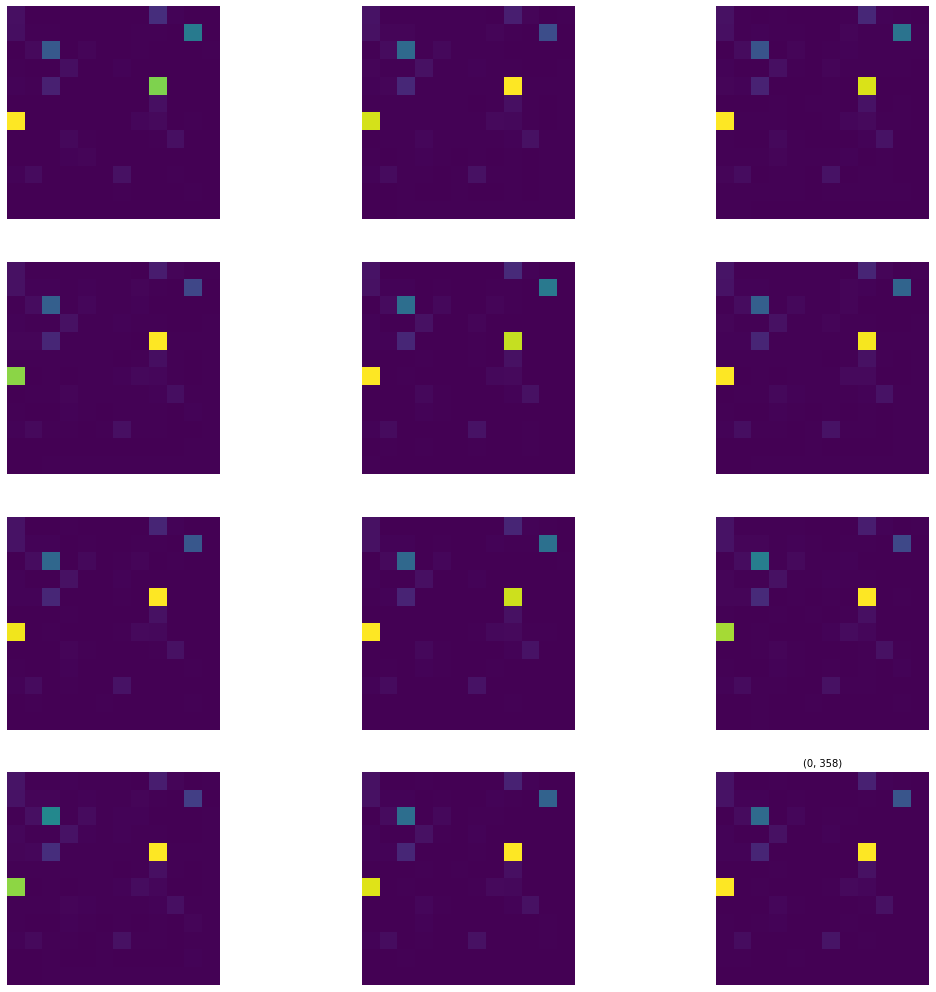

In [86]:
plot_ranom_images(0,380,12,X_tensors_train, y, (18,18), (4,3) , 10) #hleper function that takes out random sample from tensor, transmute them to the HWC format (matplotlib do not understand PyTorch native image format)

In [87]:
 # This time I'm using whole dataframe for y labels, because I have already prebuild PyTorch DataSet Class that will handle extracting y values.
train_tensor, test_tensor = train_test_split_ts(X_tensors_train, main, train_size=0.8)

In [88]:
X_train_tensor, y_train_tensor = train_tensor
X_test_tensor, y_test_tensor = test_tensor # unpacking tuples

In [89]:
def get_classes(series: pd.core.series.Series):

    classes = series.unique()
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

class MatchesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 dataframe: pd.core.frame.DataFrame, #dataframe of results, we will gety Y_labels from this
                 games: torch.Tensor, #tensor of X's
                 transform=None): #we will not be using any transorm at this stage, but I'll leave as a boiler plate for further usage.
        super().__init__()

        self.dataframe = dataframe #a dataframe as it it.
        self.games = games # our X's. We don't have to do anything with them, cause if we index this tensor, we will have a single image of a game from it.
        self.hda = self.dataframe["FTR"].to_numpy() #we are transforming pandas datafram to numpy array of Home/Draw/Away labels.
        self.classes, self.class_to_idx = get_classes(dataframe["FTR"]) #we are unpacking a function that will return us a mapped y labels.
        self.labels = torch.tensor(np.vectorize(self.class_to_idx.get)(self.hda)) #and here we are using np.vectorize to turn coresponding labels into values from 0 to 2 and then we turn them into a tensor.


    def __len__(self) -> int:
        return len(self.labels) #overwriting __len__

    def __getitem__(self, index: int): #overwriting __getitem__ and returning X&y's
    
        X = self.games[index]
        y = self.labels[index]
        
        return X,y


In [90]:
# Here we initialize a class to create a PyTorch Datasets
train_dataset = MatchesDataset(y_train_tensor,X_train_tensor) 
test_dataset = MatchesDataset(y_test_tensor,X_test_tensor)

In [91]:
#And this part of code is clustering data into minibatches and preparing an efficient datapipe for the CNN 
train_loader_tab2img = DataLoader(train_dataset, 16, shuffle=False) # we are not shuffling, to be consistent. 
test_loader_tab2img = DataLoader(test_dataset)

In [92]:
# It's not exactly a DeepInsight, but it's a similar, despite hyperparams may vary. Remember, it's a baseline only!
class DeepInsightStyleNN(nn.Module): 
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int,) -> None:


        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.conv_block_3_5 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = hidden_units),
            nn.ReLU(),
            )
        
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.Softmax()
            )

    def forward(self, x):
        return self.classifier_layer(self.conv_block_3_5(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))   #for efficiency on cuda computing we are doing this in one line.

In [93]:
deep_in_model = DeepInsightStyleNN(input_shape=1,
                    hidden_units=10,
                    output_shape=np.unique(y).shape[0]).to(device) # initialize the model

In [94]:
deep_in_model.eval()
with torch.inference_mode():
    preds = deep_in_model(X_tensors_train) # check if the output have sense

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [95]:
preds.shape # indeed, it have proper shape.

torch.Size([380, 3])

In [96]:
#Here we have to define metrics, loss function and optimizer

optimizer_deep = torch.optim.Adam(deep_in_model.parameters(),lr=0.001) #Adam as an optimizer
loss_fn_deep = nn.CrossEntropyLoss() #Cause we are dealing with multicategory classification, we will use Cross Entropy
acc_deep = torchmetrics.Accuracy(3).to(device) #and we also initialize class from torchmetrics and send it to device(cuda). 

In [97]:
# And it's a training time
for epoch in tqdm(range(180)):

    print(f"Epoch: {epoch}\n======")

    train_step(deep_in_model,train_loader_tab2img,loss_fn_deep, optimizer_deep, acc_deep, device)
    test_step(deep_in_model,test_loader_tab2img,loss_fn_deep, acc_deep, device)


  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 0

Current training loss: 1.0822710990905762
Current training acc: 0.40460526943206787%




  1%|          | 1/180 [00:00<01:03,  2.81it/s]


Current test loss: 1.0794661045074463
Current test acc: 0.4736842215061188%

Epoch: 1

Current training loss: 1.0456340312957764
Current training acc: 0.5197368264198303%




  1%|          | 2/180 [00:00<00:51,  3.48it/s]


Current test loss: 1.1125271320343018
Current test acc: 0.2631579041481018%

Epoch: 2

Current training loss: 1.031333565711975
Current training acc: 0.5526315569877625%




  2%|▏         | 3/180 [00:00<00:47,  3.76it/s]


Current test loss: 1.133478045463562
Current test acc: 0.2631579041481018%

Epoch: 3

Current training loss: 1.0212490558624268
Current training acc: 0.5592105388641357%




  2%|▏         | 4/180 [00:01<00:46,  3.81it/s]


Current test loss: 1.174180507659912
Current test acc: 0.2631579041481018%

Epoch: 4

Current training loss: 1.0131149291992188
Current training acc: 0.5625%




  3%|▎         | 5/180 [00:01<00:44,  3.91it/s]


Current test loss: 1.1956110000610352
Current test acc: 0.2368421107530594%

Epoch: 5

Current training loss: 1.0069780349731445
Current training acc: 0.5723684430122375%




  3%|▎         | 6/180 [00:01<00:44,  3.87it/s]


Current test loss: 1.2235397100448608
Current test acc: 0.19736842811107635%

Epoch: 6

Current training loss: 1.0005046129226685
Current training acc: 0.5723684430122375%




  4%|▍         | 7/180 [00:01<00:43,  4.01it/s]


Current test loss: 1.23577082157135
Current test acc: 0.21052631735801697%

Epoch: 7

Current training loss: 0.9954546093940735
Current training acc: 0.5690789222717285%




  4%|▍         | 8/180 [00:02<00:44,  3.84it/s]


Current test loss: 1.2307672500610352
Current test acc: 0.2368421107530594%

Epoch: 8

Current training loss: 0.9933936595916748
Current training acc: 0.5690789222717285%




  5%|▌         | 9/180 [00:02<00:44,  3.80it/s]


Current test loss: 1.244702696800232
Current test acc: 0.30263158679008484%

Epoch: 9

Current training loss: 0.9923107028007507
Current training acc: 0.5559210777282715%




  6%|▌         | 10/180 [00:02<00:43,  3.89it/s]


Current test loss: 1.2306638956069946
Current test acc: 0.25%

Epoch: 10

Current training loss: 0.9862443804740906
Current training acc: 0.5756579041481018%




  6%|▌         | 11/180 [00:02<00:43,  3.92it/s]


Current test loss: 1.2387348413467407
Current test acc: 0.22368420660495758%

Epoch: 11

Current training loss: 0.9818074107170105
Current training acc: 0.5723684430122375%




  7%|▋         | 12/180 [00:03<00:42,  3.93it/s]


Current test loss: 1.2604546546936035
Current test acc: 0.21052631735801697%

Epoch: 12

Current training loss: 0.9791433215141296
Current training acc: 0.5690789222717285%




  7%|▋         | 13/180 [00:03<00:42,  3.97it/s]


Current test loss: 1.219102382659912
Current test acc: 0.2631579041481018%

Epoch: 13

Current training loss: 0.9764010906219482
Current training acc: 0.5756579041481018%




  8%|▊         | 14/180 [00:03<00:41,  4.01it/s]


Current test loss: 1.2675020694732666
Current test acc: 0.21052631735801697%

Epoch: 14

Current training loss: 0.974521815776825
Current training acc: 0.5723684430122375%




  8%|▊         | 15/180 [00:03<00:40,  4.03it/s]


Current test loss: 1.234214186668396
Current test acc: 0.2368421107530594%

Epoch: 15

Current training loss: 0.9723880290985107
Current training acc: 0.5789473652839661%




  9%|▉         | 16/180 [00:04<00:40,  4.02it/s]


Current test loss: 1.25006902217865
Current test acc: 0.2368421107530594%

Epoch: 16

Current training loss: 0.9709097146987915
Current training acc: 0.5723684430122375%




  9%|▉         | 17/180 [00:04<00:40,  4.01it/s]


Current test loss: 1.2600562572479248
Current test acc: 0.21052631735801697%

Epoch: 17

Current training loss: 0.9697645306587219
Current training acc: 0.5756579041481018%




 10%|█         | 18/180 [00:04<00:39,  4.06it/s]


Current test loss: 1.2648144960403442
Current test acc: 0.22368420660495758%

Epoch: 18

Current training loss: 0.9679560661315918
Current training acc: 0.5789473652839661%




 11%|█         | 19/180 [00:04<00:40,  3.97it/s]


Current test loss: 1.2287087440490723
Current test acc: 0.2763157784938812%

Epoch: 19

Current training loss: 0.9667117595672607
Current training acc: 0.5756579041481018%




 11%|█         | 20/180 [00:05<00:40,  3.94it/s]


Current test loss: 1.272379755973816
Current test acc: 0.2368421107530594%

Epoch: 20

Current training loss: 0.9663745760917664
Current training acc: 0.5822368264198303%




 12%|█▏        | 21/180 [00:05<00:40,  3.94it/s]


Current test loss: 1.262573003768921
Current test acc: 0.2368421107530594%

Epoch: 21

Current training loss: 0.9661574959754944
Current training acc: 0.5756579041481018%




 12%|█▏        | 22/180 [00:05<00:39,  4.01it/s]


Current test loss: 1.2277334928512573
Current test acc: 0.28947368264198303%

Epoch: 22

Current training loss: 0.9660150408744812
Current training acc: 0.5822368264198303%




 13%|█▎        | 23/180 [00:05<00:39,  4.02it/s]


Current test loss: 1.2532541751861572
Current test acc: 0.2631579041481018%

Epoch: 23

Current training loss: 0.9644743204116821
Current training acc: 0.5822368264198303%




 13%|█▎        | 24/180 [00:06<00:40,  3.87it/s]


Current test loss: 1.2955178022384644
Current test acc: 0.21052631735801697%

Epoch: 24

Current training loss: 0.9630559682846069
Current training acc: 0.5822368264198303%




 14%|█▍        | 25/180 [00:06<00:41,  3.77it/s]


Current test loss: 1.2726444005966187
Current test acc: 0.2368421107530594%

Epoch: 25

Current training loss: 0.9631931185722351
Current training acc: 0.5789473652839661%




 14%|█▍        | 26/180 [00:06<00:39,  3.87it/s]


Current test loss: 1.28971529006958
Current test acc: 0.21052631735801697%

Epoch: 26

Current training loss: 0.9619544148445129
Current training acc: 0.5756579041481018%




 15%|█▌        | 27/180 [00:06<00:39,  3.86it/s]


Current test loss: 1.2739776372909546
Current test acc: 0.22368420660495758%

Epoch: 27

Current training loss: 0.9609358906745911
Current training acc: 0.5789473652839661%




 16%|█▌        | 28/180 [00:07<00:39,  3.87it/s]


Current test loss: 1.2921618223190308
Current test acc: 0.21052631735801697%

Epoch: 28

Current training loss: 0.9602903127670288
Current training acc: 0.5756579041481018%




 16%|█▌        | 29/180 [00:07<00:37,  3.98it/s]


Current test loss: 1.294642686843872
Current test acc: 0.21052631735801697%

Epoch: 29

Current training loss: 0.9592844247817993
Current training acc: 0.5921052694320679%




 17%|█▋        | 30/180 [00:07<00:37,  3.97it/s]


Current test loss: 1.2959606647491455
Current test acc: 0.21052631735801697%

Epoch: 30

Current training loss: 0.9587395191192627
Current training acc: 0.5888158082962036%




 17%|█▋        | 31/180 [00:07<00:37,  3.96it/s]


Current test loss: 1.2794294357299805
Current test acc: 0.21052631735801697%

Epoch: 31

Current training loss: 0.9578753113746643
Current training acc: 0.5921052694320679%




 18%|█▊        | 32/180 [00:08<00:37,  3.90it/s]


Current test loss: 1.3054226636886597
Current test acc: 0.19736842811107635%

Epoch: 32

Current training loss: 0.957660973072052
Current training acc: 0.5953947305679321%




 18%|█▊        | 33/180 [00:08<00:37,  3.92it/s]


Current test loss: 1.3008475303649902
Current test acc: 0.21052631735801697%

Epoch: 33

Current training loss: 0.9567453265190125
Current training acc: 0.5953947305679321%




 19%|█▉        | 34/180 [00:08<00:36,  3.95it/s]


Current test loss: 1.3116909265518188
Current test acc: 0.19736842811107635%

Epoch: 34

Current training loss: 0.9557738304138184
Current training acc: 0.5953947305679321%




 19%|█▉        | 35/180 [00:08<00:36,  3.93it/s]


Current test loss: 1.2688523530960083
Current test acc: 0.25%

Epoch: 35

Current training loss: 0.9547305703163147
Current training acc: 0.5953947305679321%




 20%|██        | 36/180 [00:09<00:37,  3.88it/s]


Current test loss: 1.2976890802383423
Current test acc: 0.2368421107530594%

Epoch: 36

Current training loss: 0.9584385752677917
Current training acc: 0.5822368264198303%




 21%|██        | 37/180 [00:09<00:36,  3.92it/s]


Current test loss: 1.263534665107727
Current test acc: 0.21052631735801697%

Epoch: 37

Current training loss: 0.9561064839363098
Current training acc: 0.5986841917037964%




 21%|██        | 38/180 [00:09<00:36,  3.88it/s]


Current test loss: 1.288134217262268
Current test acc: 0.2631579041481018%

Epoch: 38

Current training loss: 0.9553161263465881
Current training acc: 0.5921052694320679%




 22%|██▏       | 39/180 [00:09<00:36,  3.91it/s]


Current test loss: 1.3165427446365356
Current test acc: 0.21052631735801697%

Epoch: 39

Current training loss: 0.9532175660133362
Current training acc: 0.5953947305679321%




 22%|██▏       | 40/180 [00:10<00:37,  3.78it/s]


Current test loss: 1.2810418605804443
Current test acc: 0.2763157784938812%

Epoch: 40

Current training loss: 0.9542001485824585
Current training acc: 0.5953947305679321%




 23%|██▎       | 41/180 [00:10<00:36,  3.79it/s]


Current test loss: 1.2525265216827393
Current test acc: 0.30263158679008484%

Epoch: 41

Current training loss: 0.951681911945343
Current training acc: 0.5888158082962036%




 23%|██▎       | 42/180 [00:10<00:35,  3.87it/s]


Current test loss: 1.2446775436401367
Current test acc: 0.2631579041481018%

Epoch: 42

Current training loss: 0.9476603269577026
Current training acc: 0.5921052694320679%




 24%|██▍       | 43/180 [00:11<00:35,  3.90it/s]


Current test loss: 1.313096284866333
Current test acc: 0.21052631735801697%

Epoch: 43

Current training loss: 0.9487646818161011
Current training acc: 0.5953947305679321%




 24%|██▍       | 44/180 [00:11<00:34,  3.92it/s]


Current test loss: 1.2901651859283447
Current test acc: 0.22368420660495758%

Epoch: 44

Current training loss: 0.9487268328666687
Current training acc: 0.5953947305679321%




 25%|██▌       | 45/180 [00:11<00:33,  3.99it/s]


Current test loss: 1.285830020904541
Current test acc: 0.2368421107530594%

Epoch: 45

Current training loss: 0.9505670666694641
Current training acc: 0.5888158082962036%




 26%|██▌       | 46/180 [00:11<00:34,  3.88it/s]


Current test loss: 1.2580393552780151
Current test acc: 0.25%

Epoch: 46

Current training loss: 0.9463295936584473
Current training acc: 0.5855262875556946%




 26%|██▌       | 47/180 [00:12<00:34,  3.89it/s]


Current test loss: 1.3078927993774414
Current test acc: 0.22368420660495758%

Epoch: 47

Current training loss: 0.9495713114738464
Current training acc: 0.5921052694320679%




 27%|██▋       | 48/180 [00:12<00:33,  3.90it/s]


Current test loss: 1.2488223314285278
Current test acc: 0.30263158679008484%

Epoch: 48

Current training loss: 0.9519398212432861
Current training acc: 0.5789473652839661%




 27%|██▋       | 49/180 [00:12<00:33,  3.89it/s]


Current test loss: 1.277574062347412
Current test acc: 0.2631579041481018%

Epoch: 49

Current training loss: 0.9443030953407288
Current training acc: 0.6019737124443054%




 28%|██▊       | 50/180 [00:12<00:32,  3.95it/s]


Current test loss: 1.2885351181030273
Current test acc: 0.2368421107530594%

Epoch: 50

Current training loss: 0.9425556659698486
Current training acc: 0.5953947305679321%




 28%|██▊       | 51/180 [00:13<00:32,  3.97it/s]


Current test loss: 1.3081762790679932
Current test acc: 0.22368420660495758%

Epoch: 51

Current training loss: 0.9413169026374817
Current training acc: 0.6052631735801697%




 29%|██▉       | 52/180 [00:13<00:32,  3.95it/s]


Current test loss: 1.315097689628601
Current test acc: 0.21052631735801697%

Epoch: 52

Current training loss: 0.940457820892334
Current training acc: 0.6019737124443054%




 29%|██▉       | 53/180 [00:13<00:32,  3.96it/s]


Current test loss: 1.3107987642288208
Current test acc: 0.22368420660495758%

Epoch: 53

Current training loss: 0.941220223903656
Current training acc: 0.6052631735801697%




 30%|███       | 54/180 [00:13<00:32,  3.93it/s]


Current test loss: 1.266696572303772
Current test acc: 0.28947368264198303%

Epoch: 54

Current training loss: 0.9395317435264587
Current training acc: 0.5888158082962036%




 31%|███       | 55/180 [00:14<00:31,  4.01it/s]


Current test loss: 1.264784336090088
Current test acc: 0.28947368264198303%

Epoch: 55

Current training loss: 0.9423734545707703
Current training acc: 0.5822368264198303%




 31%|███       | 56/180 [00:14<00:31,  3.97it/s]


Current test loss: 1.249472975730896
Current test acc: 0.30263158679008484%

Epoch: 56

Current training loss: 0.947188138961792
Current training acc: 0.5888158082962036%




 32%|███▏      | 57/180 [00:14<00:30,  4.07it/s]


Current test loss: 1.2633450031280518
Current test acc: 0.22368420660495758%

Epoch: 57

Current training loss: 0.9418939352035522
Current training acc: 0.5953947305679321%




 32%|███▏      | 58/180 [00:14<00:30,  4.01it/s]


Current test loss: 1.298835039138794
Current test acc: 0.25%

Epoch: 58

Current training loss: 0.9376638531684875
Current training acc: 0.5986841917037964%




 33%|███▎      | 59/180 [00:15<00:30,  3.97it/s]


Current test loss: 1.3229155540466309
Current test acc: 0.21052631735801697%

Epoch: 59

Current training loss: 0.9367446899414062
Current training acc: 0.6052631735801697%




 33%|███▎      | 60/180 [00:15<00:30,  3.92it/s]


Current test loss: 1.2992684841156006
Current test acc: 0.21052631735801697%

Epoch: 60

Current training loss: 0.9346737861633301
Current training acc: 0.6052631735801697%




 34%|███▍      | 61/180 [00:15<00:30,  3.96it/s]


Current test loss: 1.2907518148422241
Current test acc: 0.21052631735801697%

Epoch: 61

Current training loss: 0.9332912564277649
Current training acc: 0.6019737124443054%




 34%|███▍      | 62/180 [00:15<00:29,  3.98it/s]


Current test loss: 1.3016966581344604
Current test acc: 0.21052631735801697%

Epoch: 62

Current training loss: 0.9334256052970886
Current training acc: 0.6052631735801697%




 35%|███▌      | 63/180 [00:16<00:29,  3.96it/s]


Current test loss: 1.2758375406265259
Current test acc: 0.22368420660495758%

Epoch: 63

Current training loss: 0.9334154725074768
Current training acc: 0.6085526347160339%




 36%|███▌      | 64/180 [00:16<00:29,  3.88it/s]


Current test loss: 1.2709741592407227
Current test acc: 0.21052631735801697%

Epoch: 64

Current training loss: 0.9307547211647034
Current training acc: 0.6052631735801697%




 36%|███▌      | 65/180 [00:16<00:29,  3.96it/s]


Current test loss: 1.3001598119735718
Current test acc: 0.25%

Epoch: 65

Current training loss: 0.9304841756820679
Current training acc: 0.6019737124443054%




 37%|███▋      | 66/180 [00:16<00:28,  3.95it/s]


Current test loss: 1.2691043615341187
Current test acc: 0.2763157784938812%

Epoch: 66

Current training loss: 0.9329898357391357
Current training acc: 0.5986841917037964%




 37%|███▋      | 67/180 [00:17<00:28,  4.00it/s]


Current test loss: 1.2499855756759644
Current test acc: 0.2368421107530594%

Epoch: 67

Current training loss: 0.9300943613052368
Current training acc: 0.5953947305679321%




 38%|███▊      | 68/180 [00:17<00:28,  3.98it/s]


Current test loss: 1.2520908117294312
Current test acc: 0.30263158679008484%

Epoch: 68

Current training loss: 0.9322320222854614
Current training acc: 0.5953947305679321%




 38%|███▊      | 69/180 [00:17<00:27,  3.97it/s]


Current test loss: 1.2591514587402344
Current test acc: 0.30263158679008484%

Epoch: 69

Current training loss: 0.9282568693161011
Current training acc: 0.6052631735801697%




 39%|███▉      | 70/180 [00:17<00:27,  3.95it/s]


Current test loss: 1.2823717594146729
Current test acc: 0.25%

Epoch: 70

Current training loss: 0.9293839335441589
Current training acc: 0.6052631735801697%




 39%|███▉      | 71/180 [00:18<00:27,  3.90it/s]


Current test loss: 1.2871191501617432
Current test acc: 0.22368420660495758%

Epoch: 71

Current training loss: 0.9272007942199707
Current training acc: 0.5986841917037964%




 40%|████      | 72/180 [00:18<00:28,  3.84it/s]


Current test loss: 1.2860294580459595
Current test acc: 0.2631579041481018%

Epoch: 72

Current training loss: 0.925327479839325
Current training acc: 0.6052631735801697%




 41%|████      | 73/180 [00:18<00:27,  3.86it/s]


Current test loss: 1.3230398893356323
Current test acc: 0.22368420660495758%

Epoch: 73

Current training loss: 0.924575686454773
Current training acc: 0.6118420958518982%




 41%|████      | 74/180 [00:18<00:27,  3.82it/s]


Current test loss: 1.3074684143066406
Current test acc: 0.22368420660495758%

Epoch: 74

Current training loss: 0.9248429536819458
Current training acc: 0.5986841917037964%




 42%|████▏     | 75/180 [00:19<00:27,  3.87it/s]


Current test loss: 1.2801421880722046
Current test acc: 0.25%

Epoch: 75

Current training loss: 0.9231910705566406
Current training acc: 0.6118420958518982%




 42%|████▏     | 76/180 [00:19<00:26,  3.96it/s]


Current test loss: 1.321591854095459
Current test acc: 0.22368420660495758%

Epoch: 76

Current training loss: 0.9200924038887024
Current training acc: 0.6184210777282715%




 43%|████▎     | 77/180 [00:19<00:26,  3.96it/s]


Current test loss: 1.3148860931396484
Current test acc: 0.21052631735801697%

Epoch: 77

Current training loss: 0.9234102368354797
Current training acc: 0.6085526347160339%




 43%|████▎     | 78/180 [00:19<00:25,  3.95it/s]


Current test loss: 1.2639758586883545
Current test acc: 0.2631579041481018%

Epoch: 78

Current training loss: 0.9217436909675598
Current training acc: 0.6151315569877625%




 44%|████▍     | 79/180 [00:20<00:25,  3.95it/s]


Current test loss: 1.2674628496170044
Current test acc: 0.28947368264198303%

Epoch: 79

Current training loss: 0.9235308766365051
Current training acc: 0.6118420958518982%




 44%|████▍     | 80/180 [00:20<00:25,  3.95it/s]


Current test loss: 1.28671395778656
Current test acc: 0.2368421107530594%

Epoch: 80

Current training loss: 0.9196547269821167
Current training acc: 0.6217105388641357%




 45%|████▌     | 81/180 [00:20<00:26,  3.72it/s]


Current test loss: 1.2608106136322021
Current test acc: 0.22368420660495758%

Epoch: 81

Current training loss: 0.9175384044647217
Current training acc: 0.6217105388641357%




 46%|████▌     | 82/180 [00:20<00:26,  3.73it/s]


Current test loss: 1.2222235202789307
Current test acc: 0.2763157784938812%

Epoch: 82

Current training loss: 0.9163978695869446
Current training acc: 0.6217105388641357%




 46%|████▌     | 83/180 [00:21<00:28,  3.46it/s]


Current test loss: 1.2275117635726929
Current test acc: 0.2763157784938812%

Epoch: 83

Current training loss: 0.9211418032646179
Current training acc: 0.6118420958518982%




 47%|████▋     | 84/180 [00:21<00:31,  3.05it/s]


Current test loss: 1.3098739385604858
Current test acc: 0.2368421107530594%

Epoch: 84

Current training loss: 0.9198300242424011
Current training acc: 0.6151315569877625%




 47%|████▋     | 85/180 [00:22<00:35,  2.67it/s]


Current test loss: 1.200352668762207
Current test acc: 0.28947368264198303%

Epoch: 85

Current training loss: 0.9178646206855774
Current training acc: 0.6282894611358643%




 48%|████▊     | 86/180 [00:22<00:31,  2.99it/s]


Current test loss: 1.287678599357605
Current test acc: 0.25%

Epoch: 86

Current training loss: 0.9175696969032288
Current training acc: 0.6217105388641357%




 48%|████▊     | 87/180 [00:22<00:28,  3.27it/s]


Current test loss: 1.317300796508789
Current test acc: 0.21052631735801697%

Epoch: 87

Current training loss: 0.9132297039031982
Current training acc: 0.6282894611358643%




 49%|████▉     | 88/180 [00:22<00:27,  3.40it/s]


Current test loss: 1.2972553968429565
Current test acc: 0.2631579041481018%

Epoch: 88

Current training loss: 0.9143020510673523
Current training acc: 0.6447368264198303%




 49%|████▉     | 89/180 [00:23<00:25,  3.54it/s]


Current test loss: 1.2830063104629517
Current test acc: 0.2368421107530594%

Epoch: 89

Current training loss: 0.9099207520484924
Current training acc: 0.6546052694320679%




 50%|█████     | 90/180 [00:23<00:24,  3.64it/s]


Current test loss: 1.2706763744354248
Current test acc: 0.2763157784938812%

Epoch: 90

Current training loss: 0.912132978439331
Current training acc: 0.6447368264198303%




 51%|█████     | 91/180 [00:23<00:23,  3.75it/s]


Current test loss: 1.301632285118103
Current test acc: 0.25%

Epoch: 91

Current training loss: 0.9104017019271851
Current training acc: 0.6480262875556946%




 51%|█████     | 92/180 [00:23<00:23,  3.76it/s]


Current test loss: 1.2497955560684204
Current test acc: 0.30263158679008484%

Epoch: 92

Current training loss: 0.914513111114502
Current training acc: 0.6480262875556946%




 52%|█████▏    | 93/180 [00:24<00:22,  3.85it/s]


Current test loss: 1.248813271522522
Current test acc: 0.30263158679008484%

Epoch: 93

Current training loss: 0.9196959137916565
Current training acc: 0.6348684430122375%




 52%|█████▏    | 94/180 [00:24<00:22,  3.84it/s]


Current test loss: 1.211276650428772
Current test acc: 0.2763157784938812%

Epoch: 94

Current training loss: 0.9124712944030762
Current training acc: 0.6282894611358643%




 53%|█████▎    | 95/180 [00:24<00:21,  3.90it/s]


Current test loss: 1.2965223789215088
Current test acc: 0.25%

Epoch: 95

Current training loss: 0.9136335253715515
Current training acc: 0.6414473652839661%




 53%|█████▎    | 96/180 [00:25<00:21,  3.86it/s]


Current test loss: 1.2410690784454346
Current test acc: 0.2763157784938812%

Epoch: 96

Current training loss: 0.9097985625267029
Current training acc: 0.6414473652839661%




 54%|█████▍    | 97/180 [00:25<00:21,  3.89it/s]


Current test loss: 1.1404829025268555
Current test acc: 0.2368421107530594%

Epoch: 97

Current training loss: 0.9076441526412964
Current training acc: 0.6447368264198303%




 54%|█████▍    | 98/180 [00:25<00:20,  3.95it/s]


Current test loss: 1.2181615829467773
Current test acc: 0.32894736528396606%

Epoch: 98

Current training loss: 0.9023513793945312
Current training acc: 0.6611841917037964%




 55%|█████▌    | 99/180 [00:25<00:20,  3.98it/s]


Current test loss: 1.2449928522109985
Current test acc: 0.28947368264198303%

Epoch: 99

Current training loss: 0.9135124683380127
Current training acc: 0.6447368264198303%




 56%|█████▌    | 100/180 [00:26<00:20,  3.94it/s]


Current test loss: 1.2201515436172485
Current test acc: 0.32894736528396606%

Epoch: 100

Current training loss: 0.9107076525688171
Current training acc: 0.6447368264198303%




 56%|█████▌    | 101/180 [00:26<00:20,  3.90it/s]


Current test loss: 1.300950050354004
Current test acc: 0.22368420660495758%

Epoch: 101

Current training loss: 0.901040256023407
Current training acc: 0.6611841917037964%




 57%|█████▋    | 102/180 [00:26<00:19,  3.96it/s]


Current test loss: 1.2709205150604248
Current test acc: 0.2763157784938812%

Epoch: 102

Current training loss: 0.903002917766571
Current training acc: 0.6546052694320679%




 57%|█████▋    | 103/180 [00:26<00:19,  3.98it/s]


Current test loss: 1.2305532693862915
Current test acc: 0.30263158679008484%

Epoch: 103

Current training loss: 0.898444414138794
Current training acc: 0.6611841917037964%




 58%|█████▊    | 104/180 [00:27<00:19,  3.89it/s]


Current test loss: 1.2284607887268066
Current test acc: 0.2763157784938812%

Epoch: 104

Current training loss: 0.8962593078613281
Current training acc: 0.6480262875556946%




 58%|█████▊    | 105/180 [00:27<00:19,  3.90it/s]


Current test loss: 1.248815655708313
Current test acc: 0.30263158679008484%

Epoch: 105

Current training loss: 0.904930830001831
Current training acc: 0.6611841917037964%




 59%|█████▉    | 106/180 [00:27<00:18,  3.98it/s]


Current test loss: 1.2517201900482178
Current test acc: 0.30263158679008484%

Epoch: 106

Current training loss: 0.9007624387741089
Current training acc: 0.6578947305679321%




 59%|█████▉    | 107/180 [00:27<00:18,  3.93it/s]


Current test loss: 1.2969915866851807
Current test acc: 0.25%

Epoch: 107

Current training loss: 0.8952025175094604
Current training acc: 0.6710526347160339%




 60%|██████    | 108/180 [00:28<00:18,  3.86it/s]


Current test loss: 1.1502275466918945
Current test acc: 0.3552631437778473%

Epoch: 108

Current training loss: 0.8963828682899475
Current training acc: 0.6546052694320679%




 61%|██████    | 109/180 [00:28<00:18,  3.76it/s]


Current test loss: 1.1765669584274292
Current test acc: 0.28947368264198303%

Epoch: 109

Current training loss: 0.8908771872520447
Current training acc: 0.6743420958518982%




 61%|██████    | 110/180 [00:28<00:18,  3.83it/s]


Current test loss: 1.3344106674194336
Current test acc: 0.18421052396297455%

Epoch: 110

Current training loss: 0.8939643502235413
Current training acc: 0.6743420958518982%




 62%|██████▏   | 111/180 [00:28<00:17,  3.84it/s]


Current test loss: 1.2662954330444336
Current test acc: 0.18421052396297455%

Epoch: 111

Current training loss: 0.8871671557426453
Current training acc: 0.6677631735801697%




 62%|██████▏   | 112/180 [00:29<00:17,  3.83it/s]


Current test loss: 1.268768072128296
Current test acc: 0.2631579041481018%

Epoch: 112

Current training loss: 0.8884668946266174
Current training acc: 0.6710526347160339%




 63%|██████▎   | 113/180 [00:29<00:17,  3.85it/s]


Current test loss: 1.1127148866653442
Current test acc: 0.44736841320991516%

Epoch: 113

Current training loss: 0.8828390836715698
Current training acc: 0.6907894611358643%




 63%|██████▎   | 114/180 [00:29<00:16,  3.89it/s]


Current test loss: 1.2324352264404297
Current test acc: 0.25%

Epoch: 114

Current training loss: 0.8823111653327942
Current training acc: 0.6875%




 64%|██████▍   | 115/180 [00:29<00:16,  3.94it/s]


Current test loss: 1.3202451467514038
Current test acc: 0.22368420660495758%

Epoch: 115

Current training loss: 0.8833745718002319
Current training acc: 0.6776315569877625%




 64%|██████▍   | 116/180 [00:30<00:16,  3.88it/s]


Current test loss: 1.253970742225647
Current test acc: 0.25%

Epoch: 116

Current training loss: 0.8766903877258301
Current training acc: 0.6940789222717285%




 65%|██████▌   | 117/180 [00:30<00:16,  3.93it/s]


Current test loss: 1.2658491134643555
Current test acc: 0.25%

Epoch: 117

Current training loss: 0.8743209838867188
Current training acc: 0.6875%




 66%|██████▌   | 118/180 [00:30<00:15,  3.91it/s]


Current test loss: 1.2171682119369507
Current test acc: 0.28947368264198303%

Epoch: 118

Current training loss: 0.8728822469711304
Current training acc: 0.6875%




 66%|██████▌   | 119/180 [00:30<00:15,  3.90it/s]


Current test loss: 1.2204225063323975
Current test acc: 0.30263158679008484%

Epoch: 119

Current training loss: 0.8707271218299866
Current training acc: 0.6907894611358643%




 67%|██████▋   | 120/180 [00:31<00:15,  3.85it/s]


Current test loss: 1.215404748916626
Current test acc: 0.30263158679008484%

Epoch: 120

Current training loss: 0.8690977692604065
Current training acc: 0.6973684430122375%




 67%|██████▋   | 121/180 [00:31<00:15,  3.80it/s]


Current test loss: 1.2541790008544922
Current test acc: 0.30263158679008484%

Epoch: 121

Current training loss: 0.8918284177780151
Current training acc: 0.6710526347160339%




 68%|██████▊   | 122/180 [00:31<00:14,  3.89it/s]


Current test loss: 1.265893816947937
Current test acc: 0.2631579041481018%

Epoch: 122

Current training loss: 0.8766440153121948
Current training acc: 0.6940789222717285%




 68%|██████▊   | 123/180 [00:31<00:14,  3.87it/s]


Current test loss: 1.2138864994049072
Current test acc: 0.28947368264198303%

Epoch: 123

Current training loss: 0.8642556071281433
Current training acc: 0.6940789222717285%




 69%|██████▉   | 124/180 [00:32<00:14,  3.85it/s]


Current test loss: 1.2019866704940796
Current test acc: 0.30263158679008484%

Epoch: 124

Current training loss: 0.8604497313499451
Current training acc: 0.7039473652839661%




 69%|██████▉   | 125/180 [00:32<00:14,  3.87it/s]


Current test loss: 1.2809348106384277
Current test acc: 0.2631579041481018%

Epoch: 125

Current training loss: 0.8595588207244873
Current training acc: 0.7072368264198303%




 70%|███████   | 126/180 [00:32<00:13,  3.95it/s]


Current test loss: 1.2688381671905518
Current test acc: 0.2763157784938812%

Epoch: 126

Current training loss: 0.8725144267082214
Current training acc: 0.6973684430122375%




 71%|███████   | 127/180 [00:32<00:13,  3.80it/s]


Current test loss: 1.289048433303833
Current test acc: 0.2368421107530594%

Epoch: 127

Current training loss: 0.9158748984336853
Current training acc: 0.6447368264198303%




 71%|███████   | 128/180 [00:33<00:13,  3.77it/s]


Current test loss: 1.0777606964111328
Current test acc: 0.4736842215061188%

Epoch: 128

Current training loss: 0.9316201210021973
Current training acc: 0.6118420958518982%




 72%|███████▏  | 129/180 [00:33<00:13,  3.82it/s]


Current test loss: 1.2514333724975586
Current test acc: 0.30263158679008484%

Epoch: 129

Current training loss: 0.9384127259254456
Current training acc: 0.5986841917037964%




 72%|███████▏  | 130/180 [00:33<00:12,  3.86it/s]


Current test loss: 1.2580336332321167
Current test acc: 0.2763157784938812%

Epoch: 130

Current training loss: 0.9065691232681274
Current training acc: 0.6677631735801697%




 73%|███████▎  | 131/180 [00:34<00:12,  3.87it/s]


Current test loss: 1.2020478248596191
Current test acc: 0.34210526943206787%

Epoch: 131

Current training loss: 0.9110755920410156
Current training acc: 0.6381579041481018%




 73%|███████▎  | 132/180 [00:34<00:12,  3.84it/s]


Current test loss: 1.1919347047805786
Current test acc: 0.32894736528396606%

Epoch: 132

Current training loss: 0.8988122344017029
Current training acc: 0.6611841917037964%




 74%|███████▍  | 133/180 [00:34<00:12,  3.91it/s]


Current test loss: 1.2676420211791992
Current test acc: 0.25%

Epoch: 133

Current training loss: 0.9003425240516663
Current training acc: 0.6513158082962036%




 74%|███████▍  | 134/180 [00:34<00:11,  3.93it/s]


Current test loss: 1.2291654348373413
Current test acc: 0.28947368264198303%

Epoch: 134

Current training loss: 0.8905645608901978
Current training acc: 0.6710526347160339%




 75%|███████▌  | 135/180 [00:35<00:11,  3.94it/s]


Current test loss: 1.0980744361877441
Current test acc: 0.44736841320991516%

Epoch: 135

Current training loss: 0.8878445029258728
Current training acc: 0.6743420958518982%




 76%|███████▌  | 136/180 [00:35<00:11,  3.88it/s]


Current test loss: 1.2546454668045044
Current test acc: 0.2631579041481018%

Epoch: 136

Current training loss: 0.8794620633125305
Current training acc: 0.6875%




 76%|███████▌  | 137/180 [00:35<00:10,  3.92it/s]


Current test loss: 1.135759711265564
Current test acc: 0.42105263471603394%

Epoch: 137

Current training loss: 0.8801068663597107
Current training acc: 0.6973684430122375%




 77%|███████▋  | 138/180 [00:35<00:10,  3.91it/s]


Current test loss: 1.241840124130249
Current test acc: 0.30263158679008484%

Epoch: 138

Current training loss: 0.872887372970581
Current training acc: 0.6973684430122375%




 77%|███████▋  | 139/180 [00:36<00:10,  3.92it/s]


Current test loss: 1.3113055229187012
Current test acc: 0.22368420660495758%

Epoch: 139

Current training loss: 0.867668628692627
Current training acc: 0.7138158082962036%




 78%|███████▊  | 140/180 [00:36<00:10,  3.91it/s]


Current test loss: 1.2345080375671387
Current test acc: 0.2763157784938812%

Epoch: 140

Current training loss: 0.8671203255653381
Current training acc: 0.7072368264198303%




 78%|███████▊  | 141/180 [00:36<00:09,  3.92it/s]


Current test loss: 1.241714358329773
Current test acc: 0.30263158679008484%

Epoch: 141

Current training loss: 0.8725901246070862
Current training acc: 0.6875%




 79%|███████▉  | 142/180 [00:36<00:09,  3.90it/s]


Current test loss: 1.1368874311447144
Current test acc: 0.3947368562221527%

Epoch: 142

Current training loss: 0.8836352825164795
Current training acc: 0.6842105388641357%




 79%|███████▉  | 143/180 [00:37<00:09,  3.87it/s]


Current test loss: 1.1913353204727173
Current test acc: 0.3552631437778473%

Epoch: 143

Current training loss: 0.8789317607879639
Current training acc: 0.6809210777282715%




 80%|████████  | 144/180 [00:37<00:09,  3.84it/s]


Current test loss: 1.1243594884872437
Current test acc: 0.40789473056793213%

Epoch: 144

Current training loss: 0.8738539814949036
Current training acc: 0.6973684430122375%




 81%|████████  | 145/180 [00:37<00:08,  3.91it/s]


Current test loss: 1.2813619375228882
Current test acc: 0.2631579041481018%

Epoch: 145

Current training loss: 0.8622170686721802
Current training acc: 0.6940789222717285%




 81%|████████  | 146/180 [00:37<00:08,  3.96it/s]


Current test loss: 1.1820224523544312
Current test acc: 0.3552631437778473%

Epoch: 146

Current training loss: 0.8618785738945007
Current training acc: 0.7006579041481018%




 82%|████████▏ | 147/180 [00:38<00:08,  3.97it/s]


Current test loss: 1.1971933841705322
Current test acc: 0.31578946113586426%

Epoch: 147

Current training loss: 0.8634222745895386
Current training acc: 0.7039473652839661%




 82%|████████▏ | 148/180 [00:38<00:08,  3.94it/s]


Current test loss: 1.1880464553833008
Current test acc: 0.32894736528396606%

Epoch: 148

Current training loss: 0.8635743856430054
Current training acc: 0.6940789222717285%




 83%|████████▎ | 149/180 [00:38<00:07,  3.88it/s]


Current test loss: 1.3371355533599854
Current test acc: 0.21052631735801697%

Epoch: 149

Current training loss: 0.8592827320098877
Current training acc: 0.7039473652839661%




 83%|████████▎ | 150/180 [00:38<00:07,  3.93it/s]


Current test loss: 1.2885310649871826
Current test acc: 0.19736842811107635%

Epoch: 150

Current training loss: 0.8592017292976379
Current training acc: 0.7039473652839661%




 84%|████████▍ | 151/180 [00:39<00:07,  3.88it/s]


Current test loss: 1.3152714967727661
Current test acc: 0.21052631735801697%

Epoch: 151

Current training loss: 0.8557465076446533
Current training acc: 0.7105262875556946%




 84%|████████▍ | 152/180 [00:39<00:07,  3.85it/s]


Current test loss: 1.2318087816238403
Current test acc: 0.2763157784938812%

Epoch: 152

Current training loss: 0.8752268552780151
Current training acc: 0.6842105388641357%




 85%|████████▌ | 153/180 [00:39<00:06,  3.87it/s]


Current test loss: 1.2584822177886963
Current test acc: 0.28947368264198303%

Epoch: 153

Current training loss: 0.8620005249977112
Current training acc: 0.7039473652839661%




 86%|████████▌ | 154/180 [00:39<00:06,  3.90it/s]


Current test loss: 1.2852524518966675
Current test acc: 0.25%

Epoch: 154

Current training loss: 0.8550406098365784
Current training acc: 0.7105262875556946%




 86%|████████▌ | 155/180 [00:40<00:06,  3.90it/s]


Current test loss: 1.2489755153656006
Current test acc: 0.30263158679008484%

Epoch: 155

Current training loss: 0.8551327586174011
Current training acc: 0.7072368264198303%




 87%|████████▋ | 156/180 [00:40<00:06,  3.85it/s]


Current test loss: 1.2634649276733398
Current test acc: 0.2763157784938812%

Epoch: 156

Current training loss: 0.8562206625938416
Current training acc: 0.7138158082962036%




 87%|████████▋ | 157/180 [00:40<00:05,  3.89it/s]


Current test loss: 1.2457071542739868
Current test acc: 0.30263158679008484%

Epoch: 157

Current training loss: 0.8546429872512817
Current training acc: 0.7171052694320679%




 88%|████████▊ | 158/180 [00:40<00:05,  3.90it/s]


Current test loss: 1.2822436094284058
Current test acc: 0.2368421107530594%

Epoch: 158

Current training loss: 0.85361248254776
Current training acc: 0.7072368264198303%




 88%|████████▊ | 159/180 [00:41<00:05,  3.92it/s]


Current test loss: 1.2509939670562744
Current test acc: 0.30263158679008484%

Epoch: 159

Current training loss: 0.8481438159942627
Current training acc: 0.7236841917037964%




 89%|████████▉ | 160/180 [00:41<00:05,  3.83it/s]


Current test loss: 1.2837940454483032
Current test acc: 0.2631579041481018%

Epoch: 160

Current training loss: 0.8489547371864319
Current training acc: 0.7171052694320679%




 89%|████████▉ | 161/180 [00:41<00:04,  3.89it/s]


Current test loss: 1.1316843032836914
Current test acc: 0.40789473056793213%

Epoch: 161

Current training loss: 0.846187174320221
Current training acc: 0.7203947305679321%




 90%|█████████ | 162/180 [00:41<00:04,  3.87it/s]


Current test loss: 1.0798155069351196
Current test acc: 0.4736842215061188%

Epoch: 162

Current training loss: 0.8501264452934265
Current training acc: 0.7138158082962036%




 91%|█████████ | 163/180 [00:42<00:04,  3.86it/s]


Current test loss: 1.3257461786270142
Current test acc: 0.18421052396297455%

Epoch: 163

Current training loss: 0.8482946157455444
Current training acc: 0.7203947305679321%




 91%|█████████ | 164/180 [00:42<00:04,  3.84it/s]


Current test loss: 1.2209112644195557
Current test acc: 0.30263158679008484%

Epoch: 164

Current training loss: 0.8549464344978333
Current training acc: 0.7105262875556946%




 92%|█████████▏| 165/180 [00:42<00:03,  3.88it/s]


Current test loss: 1.2404139041900635
Current test acc: 0.28947368264198303%

Epoch: 165

Current training loss: 0.8481084704399109
Current training acc: 0.7236841917037964%




 92%|█████████▏| 166/180 [00:43<00:03,  3.87it/s]


Current test loss: 1.3158049583435059
Current test acc: 0.21052631735801697%

Epoch: 166

Current training loss: 0.8481290936470032
Current training acc: 0.7203947305679321%




 93%|█████████▎| 167/180 [00:43<00:03,  3.83it/s]


Current test loss: 1.2772223949432373
Current test acc: 0.2631579041481018%

Epoch: 167

Current training loss: 0.842226505279541
Current training acc: 0.7138158082962036%




 93%|█████████▎| 168/180 [00:43<00:03,  3.76it/s]


Current test loss: 1.1841262578964233
Current test acc: 0.32894736528396606%

Epoch: 168

Current training loss: 0.8502966165542603
Current training acc: 0.7171052694320679%




 94%|█████████▍| 169/180 [00:43<00:02,  3.78it/s]


Current test loss: 1.2488985061645508
Current test acc: 0.30263158679008484%

Epoch: 169

Current training loss: 0.8515817523002625
Current training acc: 0.7072368264198303%




 94%|█████████▍| 170/180 [00:44<00:02,  3.84it/s]


Current test loss: 1.2528756856918335
Current test acc: 0.30263158679008484%

Epoch: 170

Current training loss: 0.8523282408714294
Current training acc: 0.7171052694320679%




 95%|█████████▌| 171/180 [00:44<00:02,  3.89it/s]


Current test loss: 1.2495495080947876
Current test acc: 0.30263158679008484%

Epoch: 171

Current training loss: 0.8499101400375366
Current training acc: 0.7105262875556946%




 96%|█████████▌| 172/180 [00:44<00:02,  3.89it/s]


Current test loss: 1.222216010093689
Current test acc: 0.31578946113586426%

Epoch: 172

Current training loss: 0.848190426826477
Current training acc: 0.7138158082962036%




 96%|█████████▌| 173/180 [00:44<00:01,  3.84it/s]


Current test loss: 1.114033579826355
Current test acc: 0.43421053886413574%

Epoch: 173

Current training loss: 0.8455994129180908
Current training acc: 0.7236841917037964%




 97%|█████████▋| 174/180 [00:45<00:01,  3.78it/s]


Current test loss: 1.0985771417617798
Current test acc: 0.44736841320991516%

Epoch: 174

Current training loss: 0.8520722389221191
Current training acc: 0.7072368264198303%




 97%|█████████▋| 175/180 [00:45<00:01,  3.85it/s]


Current test loss: 1.3271440267562866
Current test acc: 0.18421052396297455%

Epoch: 175

Current training loss: 0.8421193361282349
Current training acc: 0.7236841917037964%




 98%|█████████▊| 176/180 [00:45<00:01,  3.80it/s]


Current test loss: 1.2447925806045532
Current test acc: 0.28947368264198303%

Epoch: 176

Current training loss: 0.8391456007957458
Current training acc: 0.7269737124443054%




 98%|█████████▊| 177/180 [00:45<00:00,  3.77it/s]


Current test loss: 1.2486838102340698
Current test acc: 0.30263158679008484%

Epoch: 177

Current training loss: 0.8405091762542725
Current training acc: 0.7302631735801697%




 99%|█████████▉| 178/180 [00:46<00:00,  3.83it/s]


Current test loss: 1.277784824371338
Current test acc: 0.2763157784938812%

Epoch: 178

Current training loss: 0.8359022736549377
Current training acc: 0.7269737124443054%




 99%|█████████▉| 179/180 [00:46<00:00,  3.82it/s]


Current test loss: 1.2043004035949707
Current test acc: 0.28947368264198303%

Epoch: 179

Current training loss: 0.8327067494392395
Current training acc: 0.7236841917037964%




100%|██████████| 180/180 [00:46<00:00,  3.85it/s]


Current test loss: 1.2086223363876343
Current test acc: 0.31578946113586426%



In [98]:
model_deep_insight_evaluation = eval_model(deep_in_model,test_loader_tab2img,loss_fn_deep, acc_deep, device) # IT will create a dictionary with data

100%|██████████| 76/76 [00:00<00:00, 600.75it/s]


In [99]:
deep_insight_preds = torch.stack(model_deep_insight_evaluation["model_preds"]).squeeze().argmax(dim=1) ## hmmm some weird issue, cause it's downloading 

In [100]:
deep_insight_acc = model_deep_insight_evaluation["model_acc"]; deep_insight_acc

0.31578946113586426

In [101]:
deep_insight_compare, deep_insight_score = check_score(main, deep_insight_preds.numpy()) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
deep_insight_score #Even though we are more then two times lower on accuracy, we are quite high in the terms of the betting odds summary. It seems to be very interesting...

70.01

In [103]:
# Let's analyze this predictions a bit.
deep_insight_compare.describe()

,FTR,predictions,AvgH,AvgA,AvgD,score_odds
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.514286,0.514286,3.436857,6.194286,4.951143,2.000286
std,0.507093,0.507093,3.084534,6.087644,1.646072,1.101770
min,0.000000,0.000000,1.110000,1.260000,3.090000,1.110000
25%,0.000000,0.000000,1.405000,1.910000,3.660000,1.325000
50%,1.000000,1.000000,2.100000,3.530000,4.810000,1.460000
75%,1.000000,1.000000,4.080000,7.870000,5.670000,2.380000
max,1.000000,1.000000,12.830000,25.830000,9.780000,6.350000


In [104]:
avg_odds_per_bet_di = deep_insight_compare.describe().loc["mean"]["score_odds"]

# PyTorch Tab2Img / DeepInsight results
Algorithm perfectly overfitted the data, but when casted upon the test data somehow predicted properly games with the highest avg odds...
Even weirder is that I ran it a couple of times and it kept guessing properly those high odd games. The score was ranging from 68 to 86!

# Summary

The aim of this notebook was to compare four baseline models, and how far we are from beating the bookkeepers. Without tuning, with close to default hyperparams, we have the following output.

In [105]:
compare_dict = {"TabNet":{"score":score_tabnet,
                        "acc":tabnet_accuracy,
                        "avg_odds":avg_odds_per_bet_tabnet},
              "XGB":{"score":score_xgb,
                        "acc":xgboost_acc_test,
                     "avg_odds":avg_odds_per_bet_xgb},
              "RandomForest":{"score":score_rf,
                        "acc":rf_acc,
                        "avg_odds":avg_odds_per_bet_rf},
                "DeepInsight":{"score":deep_insight_score,
                        "acc":deep_insight_acc,
                        "avg_odds":avg_odds_per_bet_di},
                "TargetValues":{"score":76,
                        "acc":round(1/sum_of_odds*100, 4)}}


compare_df = pd.DataFrame.from_dict(compare_dict).T ; compare_df

,score,acc,avg_odds
TabNet,92.46,0.592105,2.054667
XGB,75.53,0.552632,1.798333
RandomForest,73.40,0.539474,1.790244
DeepInsight,70.01,0.315789,2.000286
TargetValues,76.00,53.151900,NaN


## TabNet we may consider already working Proof of Concept
With baseline TabNet params we are close to guessing 2 out of 3 games, so it's a very good start. But there is absolutely something worthy consideration in this DeepInsight approach. Maybe upscaling, maybe adding some layers, maybe some data manipulation and transormations... 

Nevertheless - it was all about understanding the baseline, and here we go - the baseline is already working Proof of Concept!